In [3]:
import latent_clip as open_clip
import torch
from PIL import Image
from matplotlib import pyplot as plt

# Classifying a single image

In [4]:
models = {'B-8': {'model_name':'Latent-ViT-B-8-512',
                  'pretrained':'/dlabscratch1/wendler/models/latent-clip-b-8.pt'},
          'B-4-plus':{'model_name':'Latent-ViT-B-4-512-plus',
                      'pretrained':'/dlabscratch1/wendler/models/latent-clip-b-4-plus.pt'}}
size = 'B-8'
model_name = models[size]['model_name']
pretrained = models[size]['pretrained']
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
tokenizer = open_clip.get_tokenizer(model_name)

image = preprocess(Image.open("../CLIP.jpg")).unsqueeze(0)
labels = ["a diagram", "a dog", "a cat", "two dogs", "three dogs"]
text = tokenizer(labels)

model.eval()
with torch.no_grad(), torch.cuda.amp.autocast():
    # you can either feed an image like here, or a SDXL latent of shape (batch_size, 64, 64, 4)
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs)
print("Pred:", labels[text_probs.argmax()])  

Label probs: tensor([[1.0111e-06, 1.0038e-02, 6.7027e-07, 9.4371e-01, 4.6247e-02]])
Pred: two dogs


# Webdatasets

In [3]:
import webdataset as wds
from dataclasses import dataclass
from training.data import get_wds_dataset

@dataclass
class Args:
    dataset_type: str = "webdataset-latent"
    val_data: str = "/dlabscratch1/wendler/data/laicoco-latents-sdxl-f8/aug/000/000/{000000..000081}.tar"
    val_num_samples: int = None
    train_data: str = None
    train_num_samples: int = None
    seed: int = 42
    batch_size: int = 128
    workers: int = 1
    world_size: int = 1
    train_data_upsampling_factors: float = None 

args = Args()
dataset = get_wds_dataset(args, lambda x: x, False, tokenizer=tokenizer)

In [4]:
latents, captions = next(iter(dataset.dataloader))

In [5]:
model.cuda()
model.eval()
with torch.no_grad(), torch.cuda.amp.autocast():
    # you can either feed an image like here, or a SDXL latent of shape (batch_size, 64, 64, 4)
    image_features = model.encode_image(latents.cuda().to(torch.bfloat16))
    text_features = model.encode_text(captions.cuda())
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

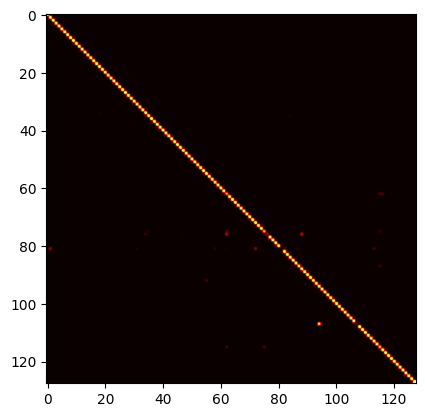

In [6]:
plt.imshow(text_probs.detach().cpu().numpy(), cmap='hot')
plt.show()

# Generated images

In [7]:
from diffusers import AutoPipelineForText2Image
pipeline = AutoPipelineForText2Image.from_pretrained("/dlabscratch1/wendler/models/miniSDXL")#'kopyl/miniSDXL')


Loading pipeline components...: 100%|██████████| 7/7 [00:26<00:00,  3.72s/it]


In [8]:
pipeline = pipeline.to("cuda")

# Test whether they VAEs are the same

In [9]:
model.visual.vae_encoder = pipeline.vae.encoder

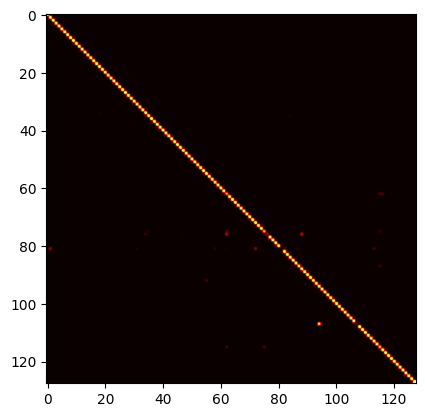

In [10]:
model.cuda()
model.eval()
with torch.no_grad(), torch.cuda.amp.autocast():
    # you can either feed an image like here, or a SDXL latent of shape (batch_size, 64, 64, 4)
    image_features = model.encode_image(latents.cuda().to(torch.bfloat16))
    text_features = model.encode_text(captions.cuda())
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
plt.imshow(text_probs.detach().cpu().numpy(), cmap='hot')
plt.show()

Ok looks like they are the same, otherwise this should not look unchanged.

In [11]:
latents.shape

torch.Size([128, 4, 64, 64])

Get summary statistics for later.

In [12]:
latents_from_encoder = latents.clone()
latents_from_encoder_mean = latents_from_encoder.mean(dim=(0, 2, 3), keepdim=True)
latents_from_encoder_std = latents_from_encoder.std(dim=(0, 2, 3), keepdim=True)

In [13]:
print(latents_from_encoder_mean)
print(latents_from_encoder_std)

tensor([[[[ 1.7250]],

         [[ 1.2593]],

         [[ 1.2548]],

         [[-1.1623]]]])
tensor([[[[10.5275]],

         [[ 5.9966]],

         [[ 7.2532]],

         [[ 5.7228]]]])


## Generate the latents

In [14]:
txts = [open_clip.tokenizer.decode(caption)[len('<start_of_text>'):] for caption in captions] 
txts = [txt.split(' <end_of_text>')[0] for txt in txts]
batch_size = 10

In [15]:
batch = []
latents = []
for txt in txts:
    batch += [txt]
    if len(batch) == batch_size:
        out = pipeline(batch, 
               width=512, 
               height=512, 
               guidance_scale=6,
               num_inference_steps=50,
               output_type="latent")
        latents += [out.images.cpu()]
        batch = []

if len(batch) > 0:
    out = pipeline(batch, 
           width=512, 
           height=512, 
           guidance_scale=6,
           num_inference_steps=50,
           output_type="latent")
    latents += [out.images.cpu()]
    batch = []

100%|██████████| 50/50 [01:39<00:00,  1.99s/it]


In [16]:
latents_from_diffusion = torch.cat(latents, dim=0)
latents_from_diffusion_mean = latents_from_diffusion.mean(dim=(0, 2, 3), keepdim=True)
latents_from_diffusion_std = latents_from_diffusion.std(dim=(0, 2, 3), keepdim=True)


In [17]:
print("Encoder latents")
print("mean", latents_from_encoder_mean)
print("std", latents_from_encoder_std)
print("Diffusion latents")
print("mean", latents_from_diffusion_mean)
print("std", latents_from_diffusion_std)

Encoder latents
mean tensor([[[[ 1.7250]],

         [[ 1.2593]],

         [[ 1.2548]],

         [[-1.1623]]]])
std tensor([[[[10.5275]],

         [[ 5.9966]],

         [[ 7.2532]],

         [[ 5.7228]]]])
Diffusion latents
mean tensor([[[[ 0.2849]],

         [[ 0.1982]],

         [[-0.0092]],

         [[ 0.0908]]]])
std tensor([[[[1.2206]],

         [[0.8399]],

         [[0.9229]],

         [[0.7873]]]])


# Clip scores before rescaling

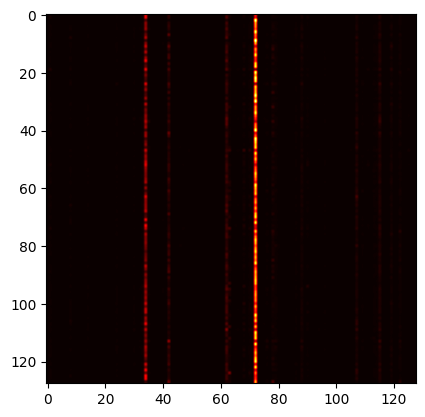

In [18]:
model.cuda()
model.eval()
with torch.no_grad(), torch.cuda.amp.autocast():
    # you can either feed an image like here, or a SDXL latent of shape (batch_size, 64, 64, 4)
    image_features = model.encode_image(latents_from_diffusion.cuda().to(torch.bfloat16))
    text_features = model.encode_text(tokenizer(txts).cuda())
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
plt.imshow(text_probs.detach().cpu().numpy(), cmap='hot')
plt.show()

# Clip scores after rescaling

In [19]:
latents = latents_from_diffusion.clone()
latents = (latents - latents_from_diffusion_mean)/latents_from_diffusion_std
latents = latents * latents_from_encoder_std + latents_from_encoder_mean

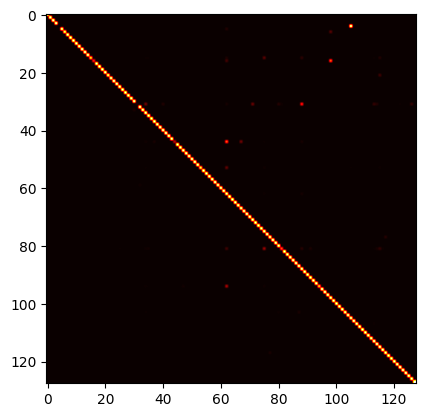

In [20]:
model.cuda()
model.eval()
with torch.no_grad(), torch.cuda.amp.autocast():
    # you can either feed an image like here, or a SDXL latent of shape (batch_size, 64, 64, 4)
    image_features = model.encode_image(latents.cuda().to(torch.bfloat16))
    text_features = model.encode_text(tokenizer(txts).cuda())
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
plt.imshow(text_probs.detach().cpu().numpy(), cmap='hot')
plt.show()

# Just applying the scaling factor as diffusers
https://github.com/huggingface/diffusers/blob/b69fd990ad8026f21893499ab396d969b62bb8cc/src/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl.py#L1231

```
 # unscale/denormalize the latents
# denormalize with the mean and std if available and not None
has_latents_mean = hasattr(self.vae.config, "latents_mean") and self.vae.config.latents_mean is not None
has_latents_std = hasattr(self.vae.config, "latents_std") and self.vae.config.latents_std is not None
if has_latents_mean and has_latents_std:
    latents_mean = (
        torch.tensor(self.vae.config.latents_mean).view(1, 4, 1, 1).to(latents.device, latents.dtype)
    )
    latents_std = (
        torch.tensor(self.vae.config.latents_std).view(1, 4, 1, 1).to(latents.device, latents.dtype)
    )
    latents = latents * latents_std / self.vae.config.scaling_factor + latents_mean
else:
    latents = latents / self.vae.config.scaling_factor

image = self.vae.decode(latents, return_dict=False)[0]

# cast back to fp16 if needed
if needs_upcasting:
    self.vae.to(dtype=torch.float16)
    ```


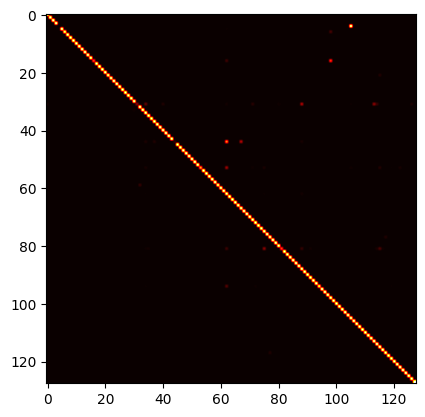

In [21]:
# mean and std is not in this config
scaling = pipeline.vae.config.scaling_factor

model.cuda()
model.eval()
with torch.no_grad(), torch.cuda.amp.autocast():
    # you can either feed an image like here, or a SDXL latent of shape (batch_size, 64, 64, 4)
    image_features = model.encode_image((latents_from_diffusion/scaling).cuda().to(torch.bfloat16))
    text_features = model.encode_text(tokenizer(txts).cuda())
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
plt.imshow(text_probs.detach().cpu().numpy(), cmap='hot')
plt.show()

# To sum up: simply dividing the latents by scalar pipeline.vae.config.scaling_factor=0.13025 is the way to go

In [22]:
pipeline.vae.config.scaling_factor 

0.13025

In [23]:
print(latents.mean(dim=(0, 2, 3), keepdim=True))
print(latents.std(dim=(0, 2, 3), keepdim=True))

print((latents_from_diffusion/scaling).mean(dim=(0, 2, 3), keepdim=True))
print((latents_from_diffusion/scaling).std(dim=(0, 2, 3), keepdim=True))


tensor([[[[ 1.7250]],

         [[ 1.2593]],

         [[ 1.2548]],

         [[-1.1623]]]])
tensor([[[[10.5275]],

         [[ 5.9966]],

         [[ 7.2532]],

         [[ 5.7228]]]])
tensor([[[[ 2.1874]],

         [[ 1.5216]],

         [[-0.0707]],

         [[ 0.6970]]]])
tensor([[[[9.3710]],

         [[6.4482]],

         [[7.0856]],

         [[6.0445]]]])


# How to handle 1024x1024 resolution = 128x128 latents?

In [24]:
out = pipeline(txts[:10], 
               width=1024, 
               height=1024, 
               guidance_scale=6,
               num_inference_steps=50,
               output_type="latent")

100%|██████████| 50/50 [10:08<00:00, 12.17s/it]


In [25]:
out.images.shape

torch.Size([10, 4, 128, 128])

In [26]:
latents_big = out.images / 0.13025
latents_pooled = torch.functional.F.avg_pool2d(latents_big, 2)

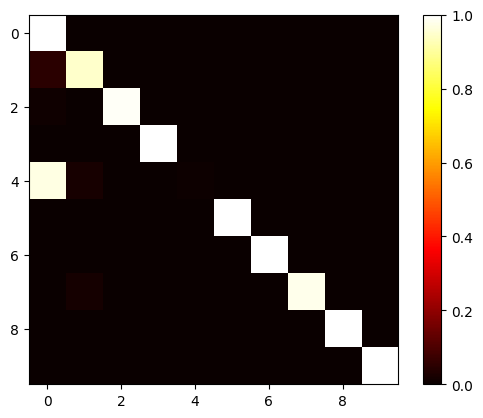

In [27]:
model.cuda()
model.eval()
with torch.no_grad(), torch.cuda.amp.autocast():
    # you can either feed an image like here, or a SDXL latent of shape (batch_size, 64, 64, 4)
    image_features = model.encode_image(latents_pooled.cuda().to(torch.bfloat16))
    text_features = model.encode_text(tokenizer(txts[:10]).cuda())
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
plt.imshow(text_probs.detach().cpu().numpy(), cmap='hot')
plt.colorbar()
plt.show()

## Deprecated, this is now fixed... I keep it for now to show some example images
## Observation: there seems to be a problem with the latents that come out of this diffusion model

The above plot should look like the identity matrix.

Maybe due to: 
* Normalization
* Incompatible VAE (I don't think that's the case)

--> Do the same experiment but applying the decoder

In [29]:
n_generated = 10
txts[:n_generated]

['physically challenged bowhunters of america',
 'britain by mass - observation by [ mass observation ] madge , charls and harrison , tom',
 'adidas alphaskin sport tight dames zwart',
 'red and green decorative christmas tree figurine trinket box enameled with swarovski elements crystals',
 'small end table with drawer how to build a awesome round saw sled plans pdf small round tables',
 'mercedes benz c - class 2 0 0 3 in good condition for sale',
 'picture of engagement ring marty 1 3 7 5 rose gold brown diamond 0 . 6 0 5 crt',
 "kappy 's american grill - morton grove : $ 1 5 for $ 3 0 worth of breakfast fare and more at kappy 's restaurant & pancake house in morton grove",
 'glaro profile half round open top receptacle , 2 4 9 6 - sa , finished in satin aluminum',
 'mini sac à dos babolat junior']

In [30]:
out = pipeline(txts[:n_generated], 
               width=512, 
               height=512, 
               guidance_scale=6,
               num_inference_steps=50)



100%|██████████| 50/50 [02:17<00:00,  2.75s/it]


physically challenged bowhunters of america


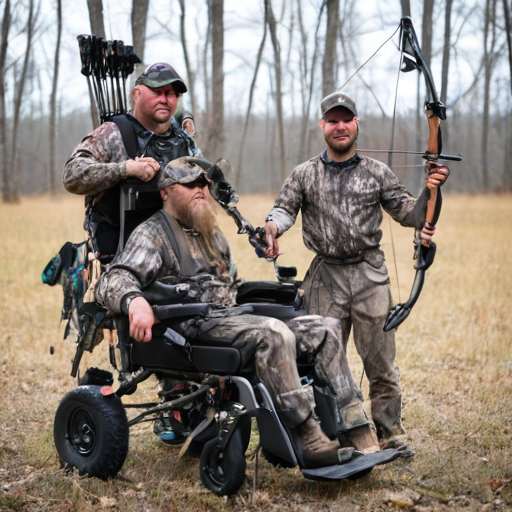

britain by mass - observation by [ mass observation ] madge , charls and harrison , tom


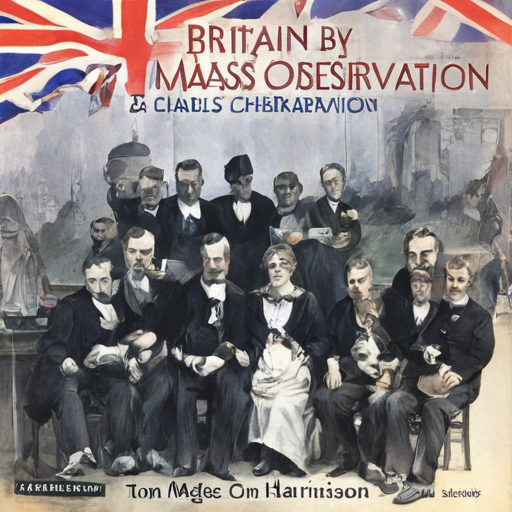

adidas alphaskin sport tight dames zwart


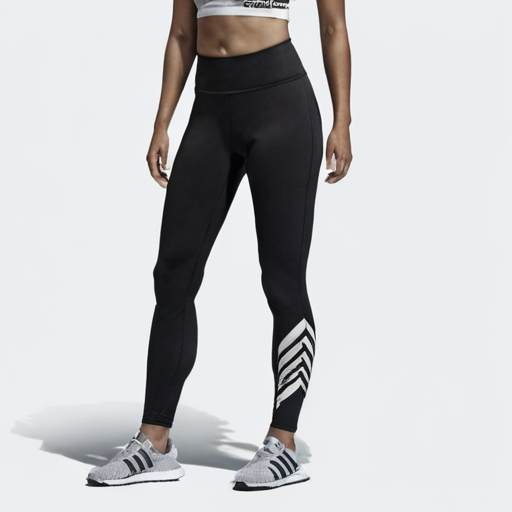

red and green decorative christmas tree figurine trinket box enameled with swarovski elements crystals


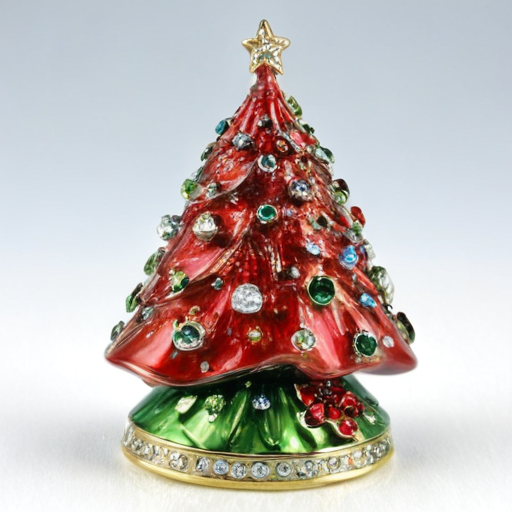

small end table with drawer how to build a awesome round saw sled plans pdf small round tables


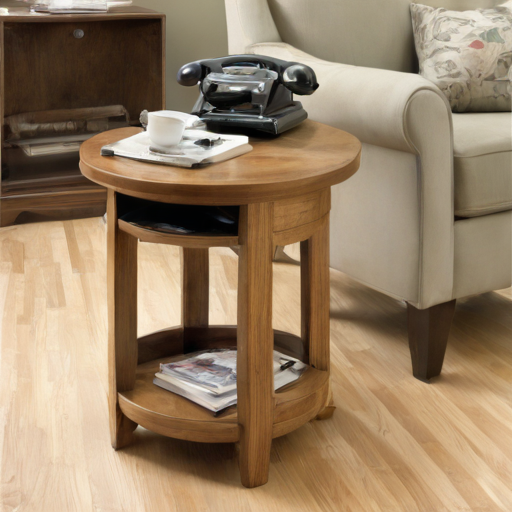

mercedes benz c - class 2 0 0 3 in good condition for sale


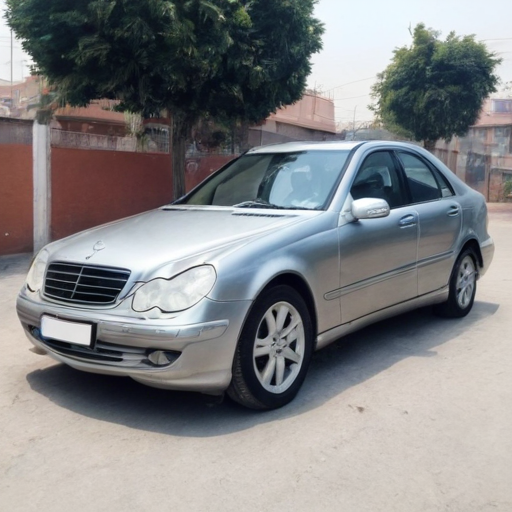

picture of engagement ring marty 1 3 7 5 rose gold brown diamond 0 . 6 0 5 crt


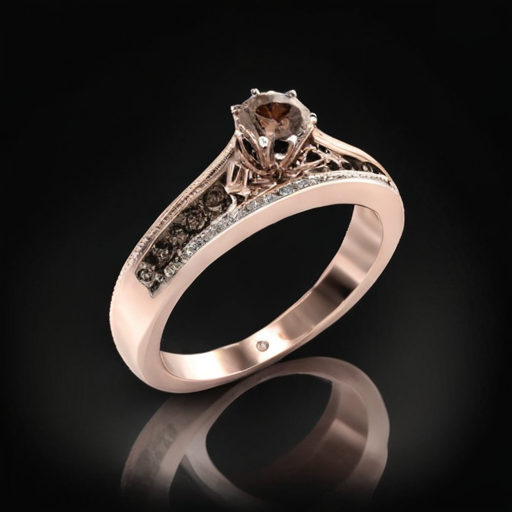

kappy 's american grill - morton grove : $ 1 5 for $ 3 0 worth of breakfast fare and more at kappy 's restaurant & pancake house in morton grove


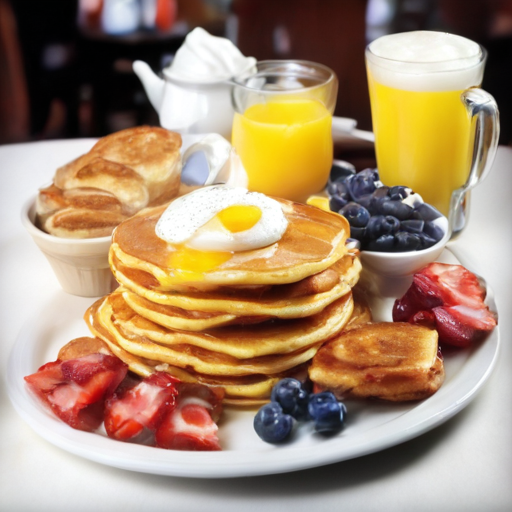

glaro profile half round open top receptacle , 2 4 9 6 - sa , finished in satin aluminum


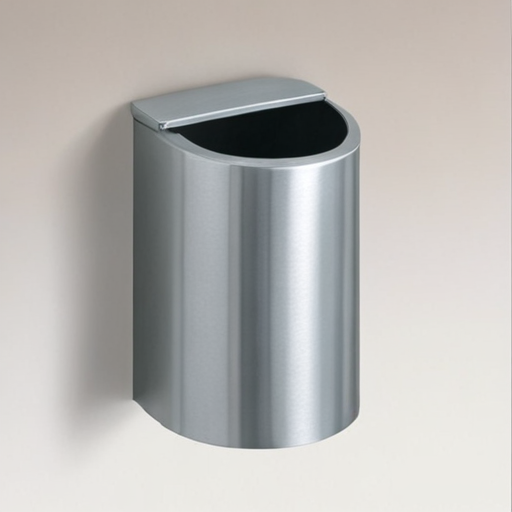

mini sac à dos babolat junior


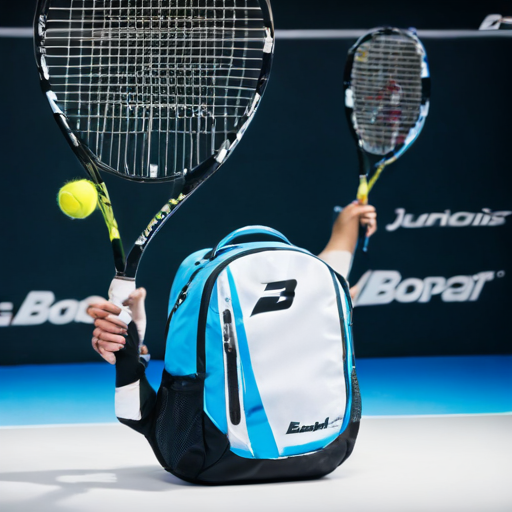

In [31]:
for img, txt in zip(out.images, txts[:n_generated]):
    print(txt)
    img.show()

In [32]:
imgs = [preprocess(img) for img in out.images]
imgs = torch.stack(imgs)

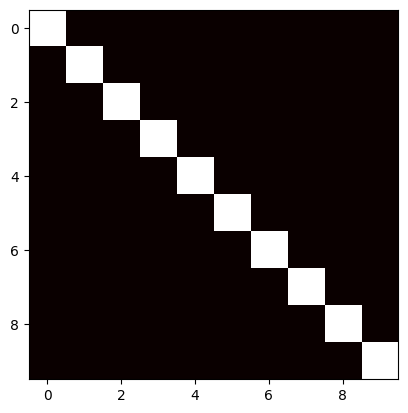

In [33]:
model.cuda()
model.eval()
with torch.no_grad(), torch.cuda.amp.autocast():
    # you can either feed an image like here, or a SDXL latent of shape (batch_size, 64, 64, 4)
    image_features = model.encode_image(imgs.cuda())
    text_features = model.encode_text(tokenizer(txts[:n_generated]).cuda())
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
plt.imshow(text_probs.detach().cpu().numpy(), cmap='hot')
plt.show()

In [34]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

14225